In [2]:
import re
import yfinance as yf
from sklearn import preprocessing
import joblib
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_MIN_LOG_LEVEL'] = "2"
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, LSTM, GRU, RNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD


# Читаем и записываем данные

In [ ]:
ntdoy = yf.Ticker('NTDOY')
old  =  ntdoy.history(period = '20y',
                      interval='1d')
data = old[['Close', 'Low', 'High']]

In [ ]:
data

(month, weekday, price) => (price)

In [ ]:
data.to_csv('actions.csv',  header=['price', 'low', 'high'])

In [ ]:
t = map(str, [1,2,3,4,66])
list(t)

# Выделяем нужные данные

In [ ]:
actions = pd.read_csv('actions.csv')
actions.head()

In [ ]:
data = []

for i in range(len(actions)):
    date = list(map(int, re.split(r'-', actions['Date'][i])))
    weekday = dt(*date).weekday()
    month = date[1]
    
    price = actions['price'][i]
    
    data.append([month, weekday, price])

In [ ]:
data = pd.DataFrame(data, columns=['month', 'weekday', 'price'])

In [ ]:
data.to_csv('actions.csv', index=False)

# Создаем модель

In [10]:
data = pd.read_csv('actions.csv')
data.head()

,month,weekday,price
0,6,0,23.335812
1,6,1,22.803726
2,6,2,22.566187
3,6,3,22.708710
4,6,4,22.233633


<AxesSubplot:>

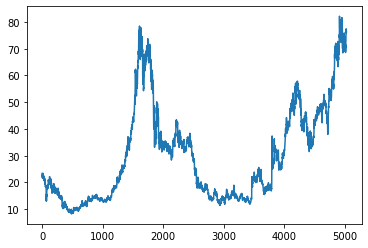

In [11]:
data['price'].plot()

In [12]:
data.describe()

,month,weekday,price
count,5032.000000,5032.000000,5032.000000
mean,6.544118,2.020072,29.816916
std,3.425680,1.400157,17.870575
min,1.000000,0.000000,8.227079
25%,4.000000,1.000000,14.560000
50%,7.000000,2.000000,23.357801
75%,10.000000,3.000000,41.099998
max,12.000000,4.000000,82.150002


#### Предобработка данных

In [13]:
min_max_m_wd = preprocessing.MinMaxScaler()
norm_m_wd = min_max_m_wd.fit_transform(data[['month','weekday']])

In [72]:
min_max_price = preprocessing.MinMaxScaler()
norm_price = min_max_price.fit_transform(data[['price']])

In [7]:
days_p = 45

In [ ]:
X_train = []
y_train = []

for i in range(0, len(norm_m_wd[:4026]), days_p):
    train = np.append(norm_m_wd[i:i+days_p], norm_price[i:i+days_p], axis=1)
    X_train.append(train)
    y_train.append(norm_price[i+days_p])  
  
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_test = []
y_test = []

for i in range(3965, 3965+len(norm_m_wd[4026:]), days_p):
    test = np.append(norm_m_wd[i:i+days_p], norm_price[i:i+days_p], axis=1)
    X_test.append(test)
    y_test.append(norm_price[i+days_p])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

#### Создаем модель

In [ ]:
print(len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

In [ ]:
model = Sequential()

model.add(Input(shape=(days_p, 3)))

model.add(GRU(units=78, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=52, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=44))
model.add(Dropout(0.2))

model.add(Dense(units=20))
model.add(Dense(units=1))

model.summary()

In [ ]:
# start = dt.now()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=16)
# print(dt.now() - start)

In [ ]:
rez = model.predict(X_test)

In [ ]:
plt.plot(range(len(rez)), rez, y_test)

In [ ]:
print(np.shape(X_train))
print(np.shape(X_test))

X_all_data = np.append(X_train, X_test, axis=0)
y_all_data = np.append(y_train, y_test, axis=0)

In [ ]:
rez = model.predict(X_all_data)

In [ ]:
plt.plot(range(len(rez)), rez, y_all_data)

In [ ]:
model.save('/home/ghost/actions/time_series_gru')

In [82]:
joblib.dump(min_max_price, 'price_norm.joblib')

['price_norm.joblib']

# Применяем

In [60]:
model = load_model('/home/ghost/actions/time_series_gru')

In [83]:
min_max_price = joblib.load('price_norm.joblib')

In [501]:
ntdoy = yf.Ticker('NTDOY')
old  =  ntdoy.history(period = '3mo',
                      interval='1d')

In [62]:
def min_max_date(month, day):
    return [(month-1)/11, day/4]

In [73]:
inp_data = old[['Close']][len(old)-days_p-1:-1].to_dict()["Close"]
new_data = []

for i in inp_data:
    date = re.findall(r'\d{4}-\d{2}-\d{2}', str(i))[0]
    date_int = map(int, date.split('-'))
    day = dt(*date_int).weekday()
    month = int(date.split('-')[1])

    price = min_max_price.transform([[inp_data[i]]])[0][0]
    month, day = min_max_date(month, day)
    
    new_data.append([month, day, price])
new_data = np.array([new_data], dtype=np.float32)

In [74]:
predict = model.predict(new_data)

In [75]:
min_max_price.inverse_transform(predict)[0, 0]

72.392